# NMT using Attention



## Import Section


In [97]:
from __future__ import absolute_import, division, print_function

# Import TensorFlow >= 1.9 and enable eager execution
import tensorflow as tf

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import string
from string import digits
import unicodedata
import re
import numpy as np
import os
import time
import warnings
warnings.filterwarnings('ignore')
print(tf.__version__)

2.9.2


## Download and prepare the dataset

In [2]:
!gdown 1mPHb2r7XGW8UiaFGw0Ew_2O8ljHLgEV9

Downloading...
From: https://drive.google.com/uc?id=1mPHb2r7XGW8UiaFGw0Ew_2O8ljHLgEV9
To: /content/english_telugu_data.txt
100% 20.3M/20.3M [00:00<00:00, 78.2MB/s]


In [3]:
path_to_file = '/content/english_telugu_data.txt'

In [4]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [5]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    w = ' '.join([contraction_mapping[word] if word in contraction_mapping else word for word in w.split(" ")])
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ." 
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    
    w = w.rstrip().strip()
    
    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w


def preprocess_sentence_telugu(text):
    # Lowercase all characters
    text = text.lower()
    # Remove quotes
    text = re.sub("'", '', text)
    # Remove all the special characters
    exclude = set(string.punctuation) # Set of all special characters
    text = ''.join([c for c in text if c not in exclude])
    # Remove all numbers from text
    remove_digits = str.maketrans('', '', digits)
    text = text.translate(remove_digits)
    # Remove Telugu numbers from text
    text = re.sub("[౦౧౨౩౪౫౬౭౮౯]", '', text)
    # Remove extra spaces
    text= text.strip()
    text = '<start> '+ text + ' <end>'
    return text

In [6]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
    lines = open(path, encoding='UTF-8').read().strip().split('\n')
    
    #word_pairs = [[preprocess_sentence(w) for w in l.split('++++$++++')]  for l in lines[:num_examples]]
    word_pairs = [l.split('++++$++++') for l in lines[:num_examples]]
    for pair in word_pairs:
      pair[0] = preprocess_sentence(pair[0])
      pair[1] = preprocess_sentence_telugu(pair[1])
    return word_pairs

In [7]:
# This class creates a word -> index mapping (e.g,. "dad" -> 5) and vice-versa 
# (e.g., 5 -> "dad") for each language,
class LanguageIndex():
  def __init__(self, lang):
    self.lang = lang
    self.word2idx = {}
    self.idx2word = {}
    self.vocab = set()
    
    self.create_index()
    
  def create_index(self):
    for phrase in self.lang:
      self.vocab.update(phrase.split(' '))
    
    self.vocab = sorted(self.vocab)
    
    self.word2idx['<pad>'] = 0
    for index, word in enumerate(self.vocab):
      self.word2idx[word] = index + 1
    
    for word, index in self.word2idx.items():
      self.idx2word[index] = word

In [8]:
def max_length(tensor):
    return max(len(t) for t in tensor)


def load_dataset(path, num_examples):
    # creating cleaned input, output pairs
    pairs = create_dataset(path, num_examples)

    # index language using the class defined above    
    inp_lang = LanguageIndex(en for en, te in pairs)
    targ_lang = LanguageIndex(te for en, te in pairs)
    
    # Vectorize the input and target languages
    
    # Spanish sentences
    input_tensor = [[inp_lang.word2idx[s] for s in en.split(' ')] for en, te in pairs]
    
    # English sentences
    target_tensor = [[targ_lang.word2idx[s] for s in te.split(' ')] for en, te in pairs]
    
    # Calculate max_length of input and output tensor
    # Here, we'll set those to the longest sentence in the dataset
    max_length_inp, max_length_tar = max_length(input_tensor), max_length(target_tensor)
    
    # Padding the input and output tensor to the maximum length
    input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, 
                                                                 maxlen=max_length_inp,
                                                                 padding='post')
    
    target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, 
                                                                  maxlen=max_length_tar, 
                                                                  padding='post')
    
    return input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_tar

### Limit the size of the dataset to experiment faster (optional)

Training on the complete dataset of >100,000 sentences will take a long time. To train faster, we can limit the size of the dataset to 30,000 sentences (of course, translation quality degrades with less data):

In [9]:
# Try experimenting with the size of that dataset
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_targ = load_dataset(path_to_file, num_examples)

In [10]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(24000, 24000, 6000, 6000)

### Create a tf.data dataset

In [11]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word2idx)
vocab_tar_size = len(targ_lang.word2idx)

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(batch_size = BATCH_SIZE,drop_remainder=True)

## Write the encoder and decoder model

Here, we'll implement an encoder-decoder model with attention which you can read about in the TensorFlow [Neural Machine Translation (seq2seq) tutorial](https://www.tensorflow.org/tutorials/seq2seq). This example uses a more recent set of APIs. This notebook implements the [attention equations](https://www.tensorflow.org/tutorials/seq2seq#background_on_the_attention_mechanism) from the seq2seq tutorial. The following diagram shows that each input words is assigned a weight by the attention mechanism which is then used by the decoder to predict the next word in the sentence.

<img src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg" width="500" alt="attention mechanism">

The input is put through an encoder model which gives us the encoder output of shape *(batch_size, max_length, hidden_size)* and the encoder hidden state of shape *(batch_size, hidden_size)*. 

Here are the equations that are implemented:

<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg" alt="attention equation 0" width="800">
<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg" alt="attention equation 1" width="800">

We're using *Bahdanau attention*. Lets decide on notation before writing the simplified form:

* FC = Fully connected (dense) layer
* EO = Encoder output
* H = hidden state
* X = input to the decoder

And the pseudo-code:

* `score = FC(tanh(FC(EO) + FC(H)))`
* `attention weights = softmax(score, axis = 1)`. Softmax by default is applied on the last axis but here we want to apply it on the *1st axis*, since the shape of score is *(batch_size, max_length, hidden_size)*. `Max_length` is the length of our input. Since we are trying to assign a weight to each input, softmax should be applied on that axis.
* `context vector = sum(attention weights * EO, axis = 1)`. Same reason as above for choosing axis as 1.
* `embedding output` = The input to the decoder X is passed through an embedding layer.
* `merged vector = concat(embedding output, context vector)`
* This merged vector is then given to the GRU
  
The shapes of all the vectors at each step have been specified in the comments in the code:

In [16]:
def gru(units):
  # If you have a GPU, we recommend using CuDNNGRU(provides a 3x speedup than GRU)
  # the code automatically does that.
  if tf.config.list_physical_devices('GPU'):
    return tf.compat.v1.keras.layers.CuDNNGRU(units, 
                                    return_sequences=True, 
                                    return_state=True, 
                                    recurrent_initializer='glorot_uniform')
  else:
    return tf.keras.layers.GRU(units, 
                               return_sequences=True, 
                               return_state=True, 
                               recurrent_activation='sigmoid', 
                               recurrent_initializer='glorot_uniform')

In [17]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.enc_units)
        
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)        
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [18]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.dec_units)
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        # used for attention
        self.W1 = tf.keras.layers.Dense(self.dec_units)
        self.W2 = tf.keras.layers.Dense(self.dec_units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        
        # score shape == (batch_size, max_length, hidden_size)
        score = tf.nn.tanh(self.W1(enc_output) + self.W2(hidden_with_time_axis))
        
        # attention_weights shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        # passing the concatenated vector to the GRU
        output, state = self.gru(x)
        
        # output shape == (batch_size * max_length, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        
        # output shape == (batch_size * max_length, vocab)
        x = self.fc(output)
        
        return x, state, attention_weights
        
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.dec_units))

In [19]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

## Define the optimizer and the loss function

In [20]:
optimizer = tf.optimizers.Adam()

def loss_function(real, pred):
  mask = 1 - np.equal(real, 0)
  loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
  return tf.reduce_mean(loss_)

## Training

1. Pass the *input* through the *encoder* which return *encoder output* and the *encoder hidden state*.
2. The encoder output, encoder hidden state and the decoder input (which is the *start token*) is passed to the decoder.
3. The decoder returns the *predictions* and the *decoder hidden state*.
4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
5. Use *teacher forcing* to decide the next input to the decoder.
6. *Teacher forcing* is the technique where the *target word* is passed as the *next input* to the decoder.
7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [21]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()
    
    hidden = encoder.initialize_hidden_state()
    total_loss = 0
    
    for (batch, (inp, targ)) in enumerate(dataset):
        loss = 0
        
        with tf.GradientTape() as tape:
            enc_output, enc_hidden = encoder(inp, hidden)
            
            dec_hidden = enc_hidden
            
            dec_input = tf.expand_dims([targ_lang.word2idx['<start>']] * BATCH_SIZE, 1)       
            
            # Teacher forcing - feeding the target as the next input
            for t in range(1, targ.shape[1]):
                # passing enc_output to the decoder
                predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
                
                loss += loss_function(targ[:, t], predictions)
                
                # using teacher forcing
                dec_input = tf.expand_dims(targ[:, t], 1)
        
        total_loss += (loss / int(targ.shape[1]))
        
        variables = encoder.variables + decoder.variables
        
        gradients = tape.gradient(loss, variables)
      
        optimizer.apply_gradients(zip(gradients, variables), tf.compat.v1.train.get_or_create_global_step())

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         loss.numpy() / int(targ.shape[1])))
    
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss/len(input_tensor)))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.8951
Epoch 1 Batch 100 Loss 1.3694
Epoch 1 Batch 200 Loss 1.2306
Epoch 1 Batch 300 Loss 1.2261
Epoch 1 Loss 0.0155
Time taken for 1 epoch 233.72811269760132 sec

Epoch 2 Batch 0 Loss 1.0400
Epoch 2 Batch 100 Loss 1.0257
Epoch 2 Batch 200 Loss 1.0575
Epoch 2 Batch 300 Loss 0.9615
Epoch 2 Loss 0.0125
Time taken for 1 epoch 225.55845665931702 sec

Epoch 3 Batch 0 Loss 0.9051
Epoch 3 Batch 100 Loss 0.9008
Epoch 3 Batch 200 Loss 0.8125
Epoch 3 Batch 300 Loss 0.7166
Epoch 3 Loss 0.0100
Time taken for 1 epoch 224.3831443786621 sec

Epoch 4 Batch 0 Loss 0.6343
Epoch 4 Batch 100 Loss 0.6147
Epoch 4 Batch 200 Loss 0.5606
Epoch 4 Batch 300 Loss 0.6852
Epoch 4 Loss 0.0075
Time taken for 1 epoch 223.26304054260254 sec

Epoch 5 Batch 0 Loss 0.4430
Epoch 5 Batch 100 Loss 0.4214
Epoch 5 Batch 200 Loss 0.4195
Epoch 5 Batch 300 Loss 0.4856
Epoch 5 Loss 0.0052
Time taken for 1 epoch 222.22158026695251 sec

Epoch 6 Batch 0 Loss 0.2568
Epoch 6 Batch 100 Loss 0.2569
Epoch 6 Batch 200 

## Translate

* The evaluate function is similar to the training loop, except we don't use *teacher forcing* here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the *end token*.
* And store the *attention weights for every time step*.

Note: The encoder output is calculated only once for one input.

In [98]:
def evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    
    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word2idx[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word2idx['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        
        # storing the attention weigths to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()
        #print(predictions)
        predicted_id = np.argmax(predictions.numpy()[0])
        #print(predicted_id)
        result += targ_lang.idx2word[int(predicted_id)] + ' '

        if targ_lang.idx2word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [107]:
!gdown https://fonts.siliconandhra.org/Mandali-Regular.ttf

Downloading...
From: https://fonts.siliconandhra.org/Mandali-Regular.ttf
To: /content/Mandali-Regular.ttf
100% 995k/995k [00:00<00:00, 1.42MB/s]


In [111]:
# function for plotting the attention weights
from matplotlib import font_manager as fm
fprop = fm.FontProperties(fname='/content/Mandali-Regular.ttf')
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize': 14}
    
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontproperties=fprop,fontdict=fontdict)

    plt.show()

In [112]:
def translate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    result, sentence, attention_plot = evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)
        
    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(result))
    
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Input: <start> hi this is test <end>
Predicted translation: ఇదంతా పరీక్ష <end> 


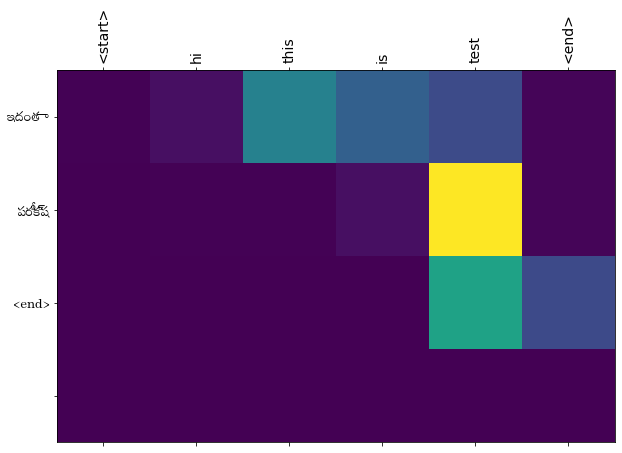

In [113]:
translate('hi this is test', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

## Lets test for some random english texts

In [127]:
test_dataset = create_dataset(path_to_file, num_examples = 7000)

****************************** Text : 3662 ******************************

Input: <start> i told tom that was ridiculous . <end>
Predicted translation: నేను హాస్యాస్పదంగా టామ్కు చెప్పాను <end> 


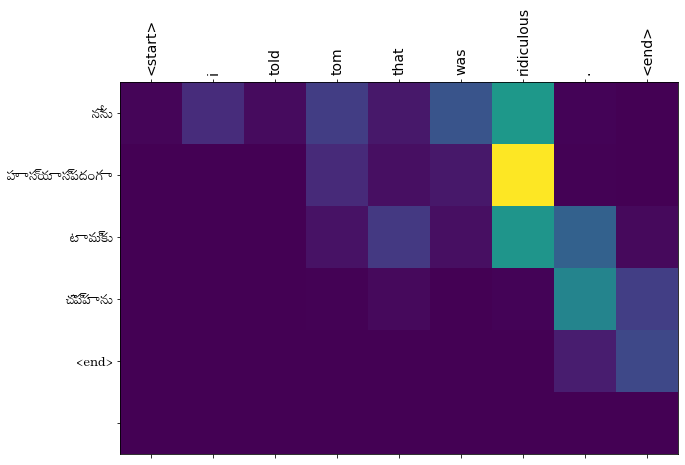

****************************** Text : 1943 ******************************

Input: <start> is not tom your brother ? <end>
Predicted translation: టామ్ మీ సోదరుడు కాదా <end> 


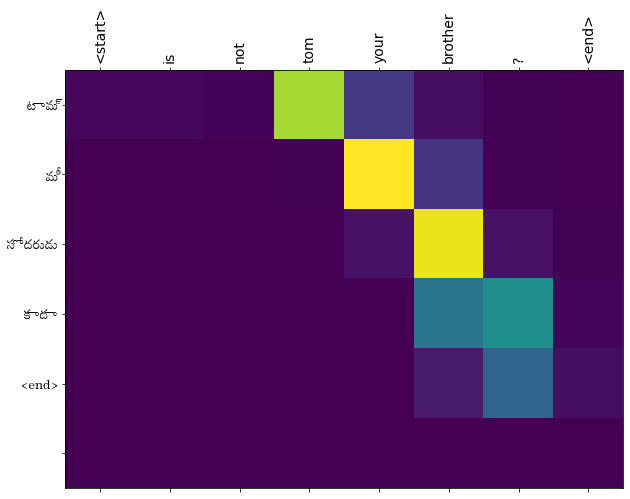

****************************** Text : 3534 ******************************

Input: <start> i was warned that somebody would try to kill me . <end>
Predicted translation: నన్ను చంపడానికి ఎవరో ప్రయత్నిస్తారని హెచ్చరించారు <end> 


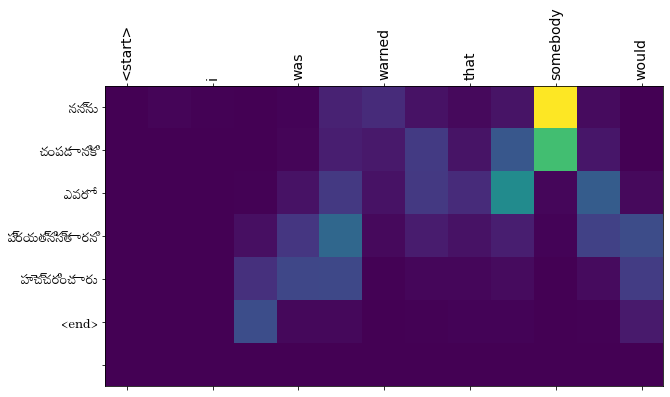

****************************** Text : 2286 ******************************

Input: <start> let us go back the way we came . <end>
Predicted translation: మనం వచ్చిన మార్గంలో తిరిగి వెళ్దాం <end> 


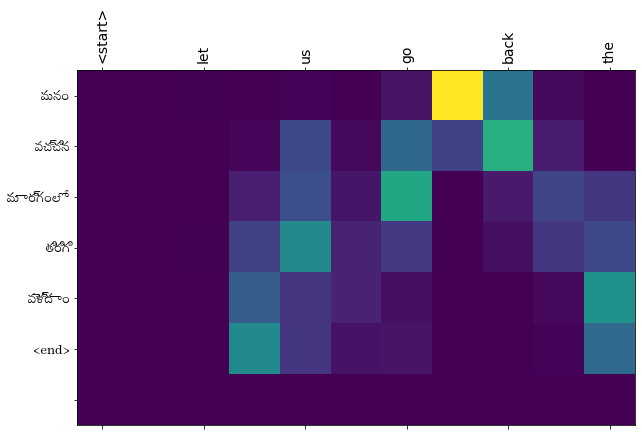

****************************** Text : 6070 ******************************

Input: <start> tom quickly got out of the car . <end>
Predicted translation: టామ్ త్వరగా కారు నుండి నిద్రపోయాడు <end> 


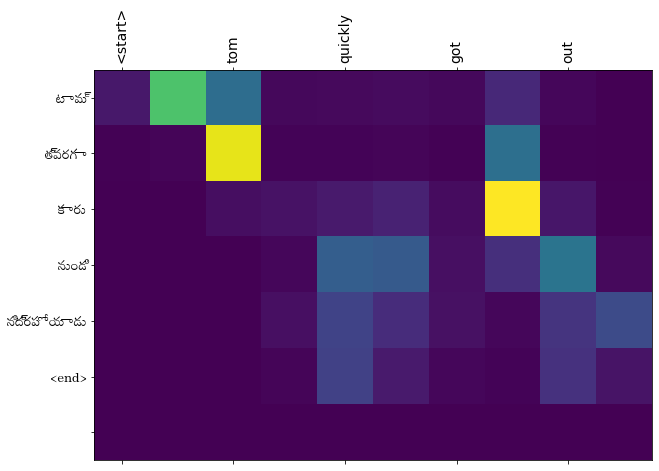

****************************** Text : 4085 ******************************

Input: <start> i know that tom is tired . <end>
Predicted translation: టామ్ అలసిపోయాడని నాకు తెలుసు <end> 


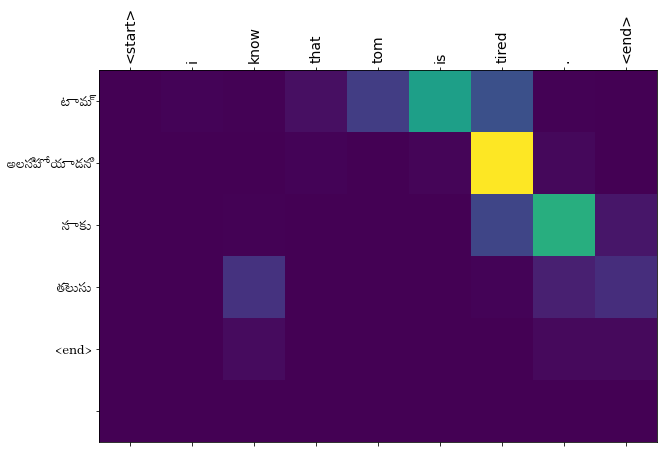

****************************** Text : 1593 ******************************

Input: <start> thanks for telling me what needed to be done . <end>
Predicted translation: ఏమి చేయాలో నాకు చెప్పినందుకు ధన్యవాదాలు <end> 


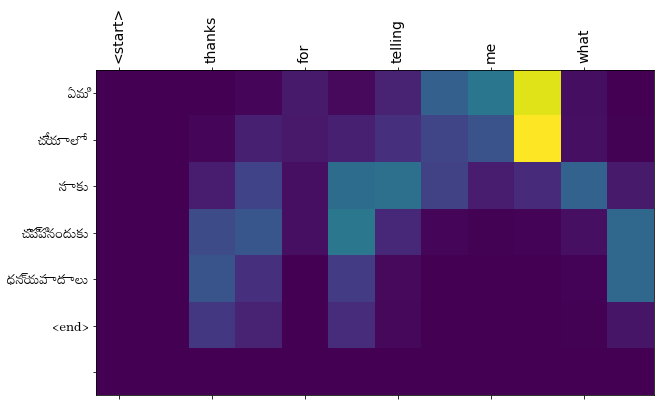

****************************** Text : 1458 ******************************

Input: <start> why cannot animals talk ? <end>
Predicted translation: ప్రజలు ఎందుకు ఆపలేరు <end> 


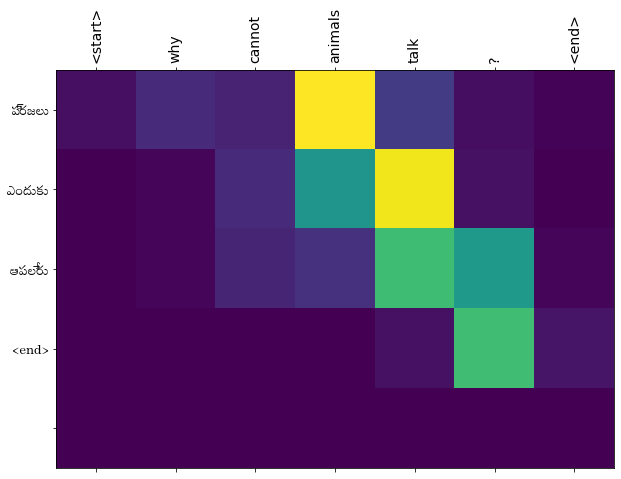

****************************** Text : 2021 ******************************

Input: <start> why did you ask me ? <end>
Predicted translation: నన్ను ఎందుకు అడిగారు <end> 


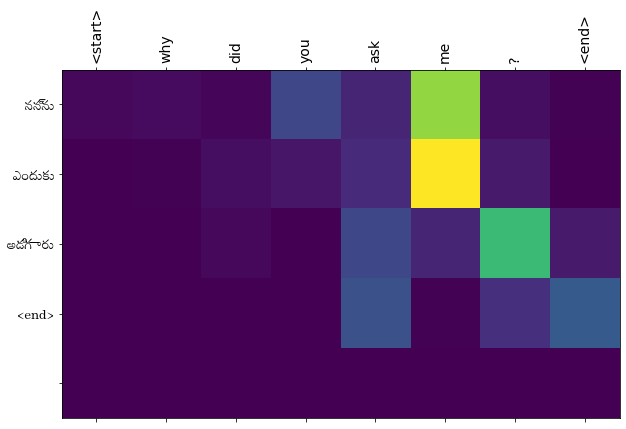

****************************** Text : 989 ******************************

Input: <start> the tea is very tasty . <end>
Predicted translation: టీ చాలా రుచికరమైనది <end> 


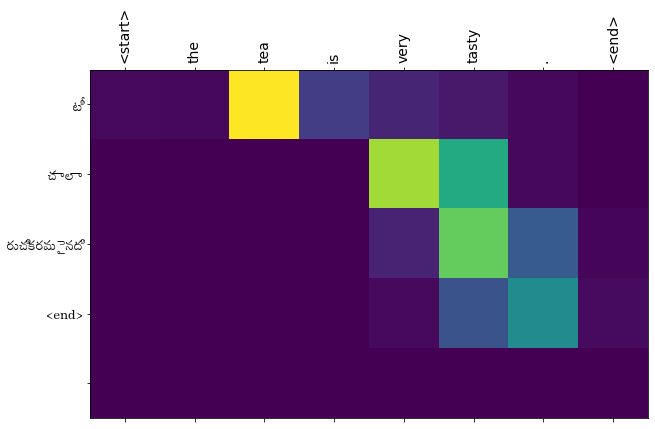

In [134]:
for i in np.random.choice(range(1,7000),size =10):
  print('*'*30 + ' Text : ' + str(i) + ' ' + '*'*30)
  text = str(test_dataset[i][0].replace('<start>','').replace('<end>','').strip())
  #print(text)
  print()
  translate(text, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)